# Generative Adversarial Networks: create paintings like Monet's

## Step 1: Introduction

One "success" of Artificial Intelligence (AI) as been to create "Deep Fakes". To create images of people who have never existed, or videos of people engaged in an activity they have never engaged in, or saying things they have never said, but with such realism that a human being is unable to distinguish an actual recording from a fake one. This is certainly one the biggest dangers of AI: to have achieved such a level of realism in generating fakes, that it has the potential to manipulate and confuse puplic opinions. Fortunately, there are more playful examples of producing fakes such as generating paintings from photographs looking just like Van Goghs or Monets.

The technique that has rendered Deep Fakes possible is called Generative Adversarial Networks [1], a kind of Turing test competition between machines. In short, a generative network is playing against a discriminative network. The generative network tries to produce a fake the discriminative network will not distinguish from a real instance, and the discriminative network tries to find tell tale signs in the fakes the generative network produces that will give it away.

For this to happen great care needs to be taken for there to be no winner: we want the game to go on forever, so both the artist and the critic will learn from one another.

This current work implements parts of CycleGAN. In Cycle GAN, the first step consists of teaching the generative network to produce pictures. For this, we use two networks, which combined, lead to two autoencoders: the first network learns to predict a photo from a monet, the second a monet from a photo. When the monet to photo network is used as an encoder and the photo to monet network as a decoder, we get a monet to monet autoencoder. Conversely, when the photo to monet is used as an encoder and the monet to photo as a decoder, we get a photo to photo autoencoder. So the first part of the notebook is spent training these two autoencoders with their respective datasets. During this part, we also focus on the photo to monet and the monet to photo networks: both have to learn to autoencode pictures, to prevent each network to predict the negative of a picture, but also to be exposed to learning another kind of input: photos for the photo network, monet paintings for the monet to photo one. 

In the second part, we extract the photo to monet network and consider it a baseline monet fakes generative network, since it should already be pretty good at predicting monets from photos. We pair it to a discriminator for fine tuning. To insure that the fakes still look like pictures, we also contrain the photo to monet network to autoencode the photos when its output is paired again with the monet to photo network. However, this ability to recover the original photo is less important than the stylistic resemblance of the fake to a Monet painting: this is reflected by the parameter lambda, a Lagrange multiplier, set to a low value, so that the objective function is weighed much more towards style imitation and less towards preserving information in the photo.

CycleGAN also includes training the monet to photo network as a photo generator from Monets, with its own discriminative network, but we did not implement this feature. Finally, in CycleGAN, all these networks train at once. We use a sequential approach.

This notebook is divided in 5 parts. First, in this introduction we perform an inspection of the data. In the second part we do an exploratory data analysis. In the third part, we present the last iteration of this work. The hyperparameter search took the form of many iterations, too many to be presented in an exhaustive way. So they are presented as a summary, included in the results section, recapitulated as a table in the fourth part. We conclude in the fifth part.

This work was inspired by Jonathan Hui's introduction on GANs [2] as well as CycleGAN [3]. Amy Jang provided great insights about implementing a CycleGAN [4]. She and her colleagues [5] provided the data.

### Inspection of the data


In [1]:
import numpy as np
import os
import time
import zipfile
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


In [2]:
monet_im_names=[]
for dump1,dump2,files in os.walk('monet_jpg'):
    for file in files:
        monet_im_names.append(file)

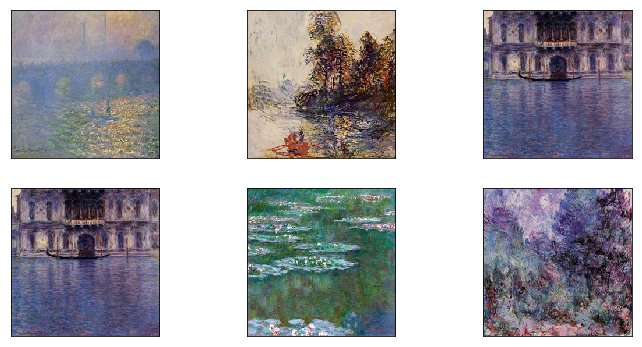

In [3]:
monet_samples=random.sample(range(len(monet_im_names)),6)
im=[plt.imread('monet_jpg/'+monet_im_names[monet_samples[idx]]) for idx in range(6)]
fig,ax=plt.subplots(2,3,figsize=(12,6))
for row in range(2):
    for column in range(3):
        ax[row,column].set_xticks([])
        ax[row,column].set_yticks([])
        ax[row,column].imshow(im[2*row+column])
plt.show()

In [4]:
photo_im_names=[]
for dump1,dump2,files in os.walk('photo_jpg'):
    for file in files:
        photo_im_names.append(file)
m_photo=len(photo_im_names)

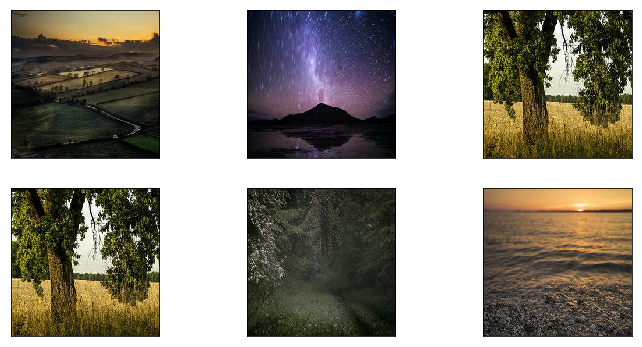

In [5]:
photo_samples=random.sample(range(len(photo_im_names)),6)
im=[plt.imread('photo_jpg/'+photo_im_names[photo_samples[idx]]) for idx in range(6)]
fig,ax=plt.subplots(2,3,figsize=(12,6))
for row in range(2):
    for column in range(3):
        ax[row,column].set_xticks([])
        ax[row,column].set_yticks([])
        ax[row,column].imshow(im[2*row+column])
plt.show()

## Step 2: exploratory data analysis

Let's look at the number of samples there are in each category: Monet paintings versus Photos

In [6]:
m_monet=len(monet_im_names)
print("There are "+str(m_monet)+" Monet paintings")
m_photo=len(photo_im_names)
print("There are "+str(m_photo)+" photos")

There are 300 Monet paintings
There are 7038 photos


<BarContainer object of 2 artists>

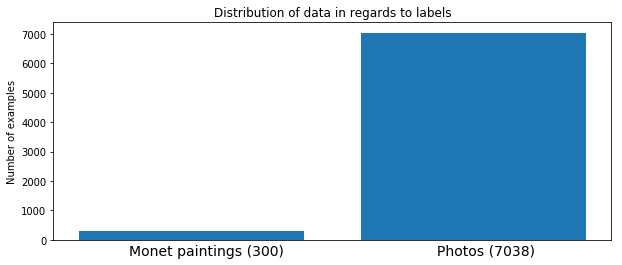

In [7]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
ax.set_xticks([])
ax.set_xlabel("Monet paintings (300)                                  Photos (7038)", fontsize=14)
ax.set_ylabel("Number of examples")
ax.set_title("Distribution of data in regards to labels")
plt.bar((0,1),(m_monet,m_photo))

There is a huge imbalance: a lot fewer paintings than photos. We will be forced to oversample the Monet set. However, given the scarcity of them, we cannot match the 7038/300 ratio without overfitting on the Monet training set. There will necessarily be an imbalance in how these are sampled. We sample the Monets 3 times as much, before overfitting occurs.

The file names are hexadecimal numbers.

In [8]:
print("The Monet file names are in the form: "+monet_im_names[0])
print("The Photos file names are in the form: "+photo_im_names[0])

The Monet file names are in the form: 000c1e3bff.jpg
The Photos file names are in the form: 00068bc07f.jpg


The image shapes is 256 by 256 pixels with 3 red, blue green channels for both the Monets and the photos. Nice!

In [9]:
im_monet=plt.imread('monet_jpg/'+monet_im_names[0])
print(im_monet.shape)

(256, 256, 3)


In [10]:
im_photo=plt.imread('photo_jpg/'+photo_im_names[0])
print(im_photo.shape)

(256, 256, 3)


The encoding is also the same: 1 byte unsigned integer.

In [11]:
print(im_monet.dtype)
print(im_photo.dtype)

uint8
uint8


When converted into 32 bit floats, the Monet data takes about 250 MB of RAM

In [12]:
print(300*256*256*3*5)
# 250 MB as floats

294912000


As for the photos, it is much more: about 7 GB: too much to fit in memory: we will need to train using an iterator loading the images from the hard drive.

In [13]:
print(7038*256*256*3*5)
# 7 GB as floats

6918635520


Based on this information we determine how to split the Monet paintings set into 270 samples used for training and 30 used for validating. As for the photos, we split the sample into 6210 photos used for training and 828 for validating. This way we can use a batch of 30 as 270 and 6210 are both divisible by 30. 

In [14]:
print(2*(3**2)*17*23)
print((2**2)*3*(5**2))
print((15+2)*2*207)
print((9+1)*30)
print(30*207+828)
print(30*9+30)
batch_size=30
monet_split=0.1
photo_split=828/7038
print(photo_split*7038)
print(7038-photo_split*7038)
print((2**2)*(3**2)*23)

7038
300
7038
300
7038
300
828.0
6210.0
828


The validation data set for the photos is much smaller: it only takes 814 MB. So we can keep it in RAM.

In [15]:
print(828*256*256*3*5)
# 814 MB as floats

813957120


We will use these numbers when splitting the data, but for now, the goal is simply to get two nested autoencoders to generate approximations of Monet images from photos, so we will not use validation data and pretrain the autoencoders on the whole data.

To do so, we convert the paintings data located in the monet_jpg folder into a numpy array. As for the photos, we will sample them first (and after each epoch), then convert them in a numpy array: this allows us to also only keep a portion of the photo data in RAM. Initially this way, we will not need to use an iterator.

In [16]:
random.seed(42)
random.shuffle(monet_im_names)
random.shuffle(photo_im_names)

In [17]:
def get_data_as_np_arrays(path,im_names):
    X=np.zeros([len(im_names),256,256,3])
    for im_idx in range(len(im_names)):
        X[im_idx,:,:,:]=np.reshape(plt.imread(path+'/'+im_names[im_idx]),[256,256,3])/255.0
    return X

In [19]:
monet_kaggle_path='../input/gan-getting-started/monet_jpg'
monet_local_path='monet_jpg'
photo_kaggle_path='../input/gan-getting-started/photo_jpg'
photo_local_path='photo_jpg'
path_monet=monet_local_path
path_photo=photo_local_path
#path_monet=monet_kaggle_path
#path_photo=photo_kaggle_path

In [20]:
X_train_monet=get_data_as_np_arrays(path_monet,monet_im_names)
photo_samples=random.sample(range(m_photo),m_monet)
photo_samples_im_names=[photo_im_names[idx] for idx in photo_samples]
X_train_photo=get_data_as_np_arrays(path_photo,photo_samples_im_names)

## Step 3: model iterations

Please refer to the result section for the hyperparameter search. For clarity we chose to focus on how this model is built first.

### Part 1: train a series of autoencoders with pictures and paintings; extract a baseline generative net

We are now almost ready to build models. We first focus on using two autoencoders: one learning to reconstruct a Monet from a Monet, which uses as encoder the monet_to_photo network and photo_to_monet as the decoder. The second one learns to reconstruct a photo from a photo, which uses as encoder the photo_to_monet network and the monet_to_photo as a decoder. This teaches the autoencoder using Monets data to learn latent features about Monets and the autoencoder using photo data to learn latent features about pictures.

However, each individual network takes a picture as an input and outputs a picture. Therefore, to learn about picture features, both networks need to learn photos and Monets. Because there are so few Monets, just training with Monets, would make the networks overfit. So we train both of them with real photos, so they can learn about picture features without overfitting. Then we fine tune the photo_to_monet network with Monet paintings so that it more specifically learns to predcit the Monet style and the monet_to_photo with Monet paintings too, so that it more specifically leans to interpret the Monet style inputs.

Below is a custom InstanceNormalization layer simply there, because this implementation of keras is old and so it did not include an InstanceNormalization class.

In [21]:
class MyInstanceNormalizationVersion(tf.keras.layers.Layer):
    def __init__(self,epsilon=1e-3):
        super().__init__()
        self.epsilon=epsilon
        
    def call(self,inputs):
        instance_mean=tf.reshape(tf.reduce_mean(tf.reduce_mean(tf.reduce_mean(inputs,axis=3),axis=2),axis=1),[-1,1,1,1])
        instance_var=tf.reduce_mean(tf.reduce_mean(tf.reduce_mean((inputs-instance_mean)**2,axis=3),axis=2),axis=1)
        instance_std_dev=tf.reshape(tf.sqrt(instance_var),[-1,1,1,1])
        return (inputs-instance_mean)/(instance_std_dev+self.epsilon)

Each network is a convolutional net with residuals short circuting same level layers, as inspired by Amy Jang [4]. This facilitates gradient propagation while still allowing finer adjustments.

In [22]:
inputs=tf.keras.Input(shape=(256,256,3))
x=tf.keras.layers.Conv2D(64,kernel_size=(4,4),strides=(2,2),padding='same', input_shape=(256, 256, 3), use_bias=False)(inputs)
x1=tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x=tf.keras.layers.Conv2D(128,kernel_size=(4,4),strides=(2,2),padding='same', use_bias=False)(x1)
x=MyInstanceNormalizationVersion()(x)
x2=tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x=tf.keras.layers.Conv2D(256,kernel_size=(4,4),strides=(2,2),padding='same', use_bias=False)(x2)
x=MyInstanceNormalizationVersion()(x)
x=tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x=tf.keras.layers.Conv2DTranspose(128,kernel_size=(4,4),strides=(2,2),padding='same', use_bias=False)(x)
x=MyInstanceNormalizationVersion()(x)
x=tf.keras.layers.Activation(activation='relu')(x)
x=tf.keras.layers.Concatenate(axis=3)([x,x2])
x=tf.keras.layers.Conv2DTranspose(64,kernel_size=(4,4),strides=(2,2),padding='same', use_bias=False)(x)
x=MyInstanceNormalizationVersion()(x)
x=tf.keras.layers.Activation(activation='relu')(x)
x=tf.keras.layers.Concatenate(axis=3)([x,x1])
x=tf.keras.layers.Conv2DTranspose(3,kernel_size=(4,4),strides=(2,2),padding='same')(x)
x=MyInstanceNormalizationVersion()(x)
outputs=tf.keras.layers.Activation('sigmoid')(x)
monet_to_photo=tf.keras.Model(inputs=inputs,outputs=outputs)

In [23]:
monet_to_photo.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 128)  131072      leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
my_instanc

In [24]:
inputs=tf.keras.Input(shape=(256,256,3))
x=tf.keras.layers.Conv2D(64,kernel_size=(4,4),strides=(2,2),padding='same', input_shape=(256, 256, 3), use_bias=False)(inputs)
x1=tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x=tf.keras.layers.Conv2D(128,kernel_size=(4,4),strides=(2,2),padding='same', use_bias=False)(x1)
x=MyInstanceNormalizationVersion()(x)
x2=tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x=tf.keras.layers.Conv2D(256,kernel_size=(4,4),strides=(2,2),padding='same', use_bias=False)(x2)
x=MyInstanceNormalizationVersion()(x)
x=tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x=tf.keras.layers.Conv2DTranspose(128,kernel_size=(4,4),strides=(2,2),padding='same', use_bias=False)(x)
x=MyInstanceNormalizationVersion()(x)
x=tf.keras.layers.Activation(activation='relu')(x)
x=tf.keras.layers.Concatenate(axis=3)([x,x2])
x=tf.keras.layers.Conv2DTranspose(64,kernel_size=(4,4),strides=(2,2),padding='same', use_bias=False)(x)
x=MyInstanceNormalizationVersion()(x)
x=tf.keras.layers.Activation(activation='relu')(x)
x=tf.keras.layers.Concatenate(axis=3)([x,x1])
x=tf.keras.layers.Conv2DTranspose(3,kernel_size=(4,4),strides=(2,2),padding='same')(x)
x=MyInstanceNormalizationVersion()(x)
outputs=tf.keras.layers.Activation('sigmoid')(x)
photo_to_monet=tf.keras.Model(inputs=inputs,outputs=outputs)

In [25]:
photo_to_monet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 128, 128, 64) 3072        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 128)  131072      leaky_re_lu_4[0][0]              
__________________________________________________________________________________________________
my_instanc

In [26]:
ae_monet_input = tf.keras.Input(shape=(256,256,3))
ae_monet_latent = monet_to_photo(ae_monet_input)
ae_monet_output = photo_to_monet(ae_monet_latent)
ae_monet= tf.keras.Model(inputs=ae_monet_input,outputs=ae_monet_output)

In [27]:
ae_photo_input = tf.keras.Input(shape=(256,256,3))
ae_photo_latent = photo_to_monet(ae_photo_input)
ae_photo_output = monet_to_photo(ae_photo_latent)
ae_photo= tf.keras.Model(inputs=ae_photo_input,outputs=ae_photo_output)

In [28]:
ae_monet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
model_1 (Model)              (None, 256, 256, 3)       1451011   
_________________________________________________________________
model_2 (Model)              (None, 256, 256, 3)       1451011   
Total params: 2,902,022
Trainable params: 2,902,022
Non-trainable params: 0
_________________________________________________________________


We use a sigmoid output with the corresponding binary cross-entropy loss, because then the outputs are always between 0 and 1. With linear output layers and the mean absolute error, outputs can get slightly below zero or above one, which makes clipping necessary thus altering the pictures.

In [29]:
monet_to_photo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [30]:
photo_to_monet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [31]:
ae_monet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [32]:
ae_photo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [33]:
start_time=time.time()
n_cycles=6
train_loss_history=np.zeros([n_cycles])
for cycle in range(n_cycles):
    photo_samples=random.sample(range(m_photo),m_monet)
    photo_samples_im_names=[photo_im_names[idx] for idx in photo_samples]
    X_train_photo=get_data_as_np_arrays(path_photo,photo_samples_im_names)
    
    history_ae_monet=ae_monet.fit(X_train_monet,X_train_monet,epochs=2,verbose=1,shuffle=True)
    history_ae_photo=ae_photo.fit(X_train_photo,X_train_photo,epochs=2,verbose=1,shuffle=False)
    history_monet=monet_to_photo.fit(X_train_monet,X_train_monet,epochs=2,verbose=1,shuffle=True)
    history_photo=photo_to_monet.fit(X_train_photo,X_train_photo,epochs=2,verbose=1,shuffle=False)
    train_loss_history[cycle]=np.mean(np.array(history_ae_monet.history['loss']))+np.array(history_ae_photo.history['loss'][0])
    train_loss_history[cycle]+=np.mean(np.array(history_monet.history['loss']))+np.array(history_photo.history['loss'][0])
    train_loss_history[cycle]/=4.0
end_time=time.time()
time_spent_training = end_time - start_time
print('\nIt took '+str(int(time_spent_training)//60)+' minutes and '+str(int(time_spent_training)%60)+' seconds to train')     
    

Epoch 1/2
300/300 [==============================] - 17s 56ms/step - loss: 0.7154 - acc: 0.0043
Epoch 2/2
300/300 [==============================] - 10s 32ms/step - loss: 0.6515 - acc: 0.0054
Epoch 1/2
300/300 [==============================] - 11s 38ms/step - loss: 0.6634 - acc: 0.0227
Epoch 2/2
300/300 [==============================] - 10s 32ms/step - loss: 0.6274 - acc: 0.0248
Epoch 1/2
300/300 [==============================] - 6s 21ms/step - loss: 0.8180 - acc: 0.0026
Epoch 2/2
300/300 [==============================] - 5s 18ms/step - loss: 0.6774 - acc: 0.0049
Epoch 1/2
300/300 [==============================] - 6s 22ms/step - loss: 0.7388 - acc: 0.0193
Epoch 2/2
300/300 [==============================] - 5s 18ms/step - loss: 0.6289 - acc: 0.0248
Epoch 1/2
300/300 [==============================] - 10s 32ms/step - loss: 0.6561 - acc: 0.0053
Epoch 2/2
300/300 [==============================] - 10s 32ms/step - loss: 0.6483 - acc: 0.0055
Epoch 1/2
300/300 [=========================

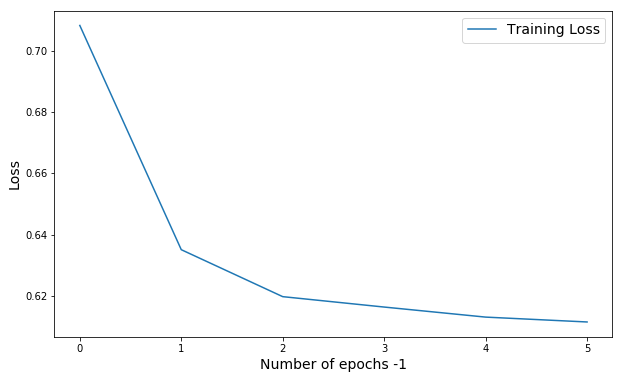

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(train_loss_history,label='Training Loss')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.legend(loc="upper right", fontsize=14)

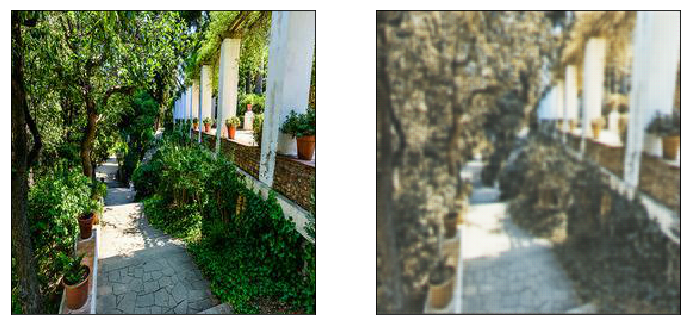

In [38]:
rd_photos_np=np.zeros([2,256,256,3])
rd_photos_np[0,:,:,:]=np.reshape(plt.imread(path_photo+'/'+random.choice(photo_im_names)),[256,256,3])/255.0
rd_photos_np[1,:,:,:]=np.reshape(plt.imread(path_photo+'/'+random.choice(photo_im_names)),[256,256,3])/255.0
fake_monets=photo_to_monet.predict(rd_photos_np)
fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].imshow(rd_photos_np[0,:,:,:])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].imshow(fake_monets[0,:,:,:])
plt.show()

The left picture is the photo and the right one is supposed to look like a Monet. Unfortunately, because the photo to monet network was also trained with lots of photos, for now, it looks a lot more like a photo than a painting. This will change with adversarial training.

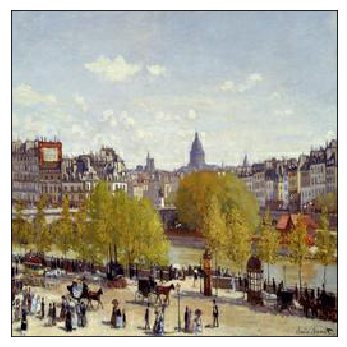

In [40]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(X_train_monet[0,:,:,:])
plt.show()

### Part 2: putting the GAN loss back in

As aluded to in the introduction, the discriminator plays a role of critique to the generator student to teach it to paint Monets better. This is an easy role: if the discriminator trains too quickly, then it will overpower the capacities of the student to change and win all the time, no matter what the generator throws at it. If the generator trains too quickly, it will learn features that fooled a novice discriminator, but then have a hard time finding new strategies when the discriminator finally discovers the treachery. It may even then double down and dig itself a hole. 

We want both the discriminator to improve with time, and not one at the expense of the other. The generator has for objective to minimize the cross-entropy between the labels distribution, always 1s for Monets, and that of its creations. The discriminator's objective on the other hand is to minimize two cross-entropies: the cross-entropy between its predictions and that of the labels for the Monets and the cross-entropy between its predictions and that of the labels for fakes, always 0s. These are precisely the loss functions we chose, so by monitoring the sum (or mean) of these three losses, we can see if the network is making progress or not, in imitating the Monet style. Similarly we can look at the mean of the accuracies.

To make sure the two networks learn at the same pace, knowing the discriminator usually has the upper hand, we give the opportunity for the generator to have many drafts graded (the parameter n_fakes below, set to a 100). When it reaches at least 50 %, it can take a break. Then the discriminator has one opportunity for professional development: looking at the Monets and the same number of pictures again, and improve its grading practice. In general, if it gets too good, 85%, that usually means the student is really failing.

Finally, there is the cycle loss: we burden the student (as students, we get asked soo much of ourselves) even more, we require that it keeps the information of the orginal photo in its fake, as to be able to reconstruct the photo. Well, we don't insist much on this requirement: the LAMBDA multiplier is set to 0.000001. It turns out that more is often too much (I told you).

In [42]:
# Saves the weights of the networks above to avoid retraining just the autoencoders
#np.savez('../tmp/monet_to_photo_weights2',monet_to_photo.get_weights())
#np.savez('../tmp/photo_to_monet_weights2',photo_to_monet.get_weights())

In [36]:
discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,kernel_size=4,strides=2,padding='same', input_shape=(256, 256, 3)),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    MyInstanceNormalizationVersion(),
    tf.keras.layers.Conv2D(128,kernel_size=4,strides=2,padding='same', use_bias=False),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    MyInstanceNormalizationVersion(),
    tf.keras.layers.Conv2D(256,kernel_size=4,strides=2,padding='same', use_bias=False),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    MyInstanceNormalizationVersion(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
my_instance_normalization_ve (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 128)       131072    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
my_instance_normalization_ve (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 256)       524288    
__________

In [37]:
class DiscriminatorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.85):
            print("\nDiscriminator reached 85% accuracy")
            self.model.stop_training = True

d_callbacks = DiscriminatorCallback()


In [38]:
class GeneratorCallback(tf.keras.callbacks.Callback):
    def on_batch_end(self, batch, logs={}):
        if(logs.get('acc')>0.5):
            print("\nGenerator reached 50% accuracy so cancelling training!")
            self.model.stop_training = True

g_callbacks = GeneratorCallback()


In [39]:
discriminator.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.000005), loss='binary_crossentropy',metrics=['acc'])

During the generator training, we do not want the weights of the discriminator to be modified. When using Tensforflow 2.x as backend, there is the opportunity to use tf.Gradient tape. Not with Tensorflow 1.x. Rather, here, we still use the Keras .fit method to train: so we use it with a network that is the combination of the generator followed by a copy of the discriminator with non trainable weights, into which we load the discriminator's weights.

In [40]:
discriminator_fixed = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,kernel_size=4,strides=2,padding='same', input_shape=(256, 256, 3),trainable=False),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    MyInstanceNormalizationVersion(),
    tf.keras.layers.Conv2D(128,kernel_size=4,strides=2,padding='same',trainable=False,use_bias=False),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    MyInstanceNormalizationVersion(),
    tf.keras.layers.Conv2D(256,kernel_size=4,strides=2,padding='same',trainable=False,use_bias=False),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    MyInstanceNormalizationVersion(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1,activation='sigmoid',trainable=False)
])

discriminator_fixed.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
my_instance_normalization_ve (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 128)       131072    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 64, 64, 128)       0         
_________________________________________________________________
my_instance_normalization_ve (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 256)       524288    
__________

In [41]:
combined_photo_input = tf.keras.Input(shape=(256,256,3))
fake_im = photo_to_monet(combined_photo_input)
combined_output = discriminator_fixed(fake_im)
combined= tf.keras.Model(inputs=combined_photo_input,outputs=combined_output)

In [42]:
combined.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.000005), loss='binary_crossentropy',metrics=['acc'])

Earlier, we trained the networks on the whole data to get starting images to feed to the discriminator. This time, we will use validation data to assess training. So we need to split the data we have.

In [39]:
from sklearn.model_selection import train_test_split
monet_train_im_names,monet_val_im_names=train_test_split(np.array(monet_im_names),test_size=monet_split)
photo_train_im_names,photo_val_im_names=train_test_split(np.array(photo_im_names),test_size=photo_split)

In [40]:
print(monet_train_im_names.shape[0])
print(monet_val_im_names.shape[0])
print(photo_train_im_names.shape[0])
print(photo_val_im_names.shape[0])

270
30
6210
828


In [42]:
X_train_monet=get_data_as_np_arrays('monet_jpg/',monet_train_im_names)
X_val_monet=get_data_as_np_arrays('monet_jpg/',monet_val_im_names)
X_val_photo=get_data_as_np_arrays('photo_jpg/',photo_val_im_names)

This was for the images. Now the labels. Missing are the labels when training the discriminator with fakes. This is because we use an iterator, also call generator which calls the "get_n_photos" method. We actually have to use two different iterators: one for the photo autoencoder, the other one for the generative network: the photo to monet network. This is because, the former has photos as labels and the second has ones as labels.

In [43]:
l_val_photo=np.ones([len(photo_val_im_names)])
l_train_monet=np.ones([len(monet_train_im_names)])
l_val_monet=np.ones([len(monet_val_im_names)])

In [44]:
class MyGenerator(keras.utils.Sequence):
    def __init__(self,im_names,batch_size,path):
        self.im_names=im_names
        self.batch_size=int(batch_size)
        self.path=path
        
    def __len__(self):
        return len(self.im_names)//self.batch_size
    
    def __getitem__(self,idx):
        batch_im=self.im_names[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_x = np.array([np.reshape(plt.imread(self.path+im_name),[256,256,3]) for im_name in batch_im])/255.0
        return batch_x,batch_x

In [45]:
photo_generator=iter(MyGenerator(photo_train_im_names,batch_size,'photo_jpg/'))

In [46]:
def get_n_photos(n,generator,batch_size):
    photos=np.zeros([n,256,256,3])
    for idx in range(n//batch_size):
        photos[idx*batch_size:(idx+1)*batch_size,:,:,:],dump=next(generator)
    return photos

In [47]:
class MyGenerator2(keras.utils.Sequence):
    def __init__(self,im_names,batch_size,path):
        self.im_names=im_names
        self.batch_size=int(batch_size)
        self.path=path
        
    def __len__(self):
        return len(self.im_names)//self.batch_size
    
    def __getitem__(self,idx):
        batch_l=np.ones([self.batch_size])
        batch_im=self.im_names[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_x = np.array([np.reshape(plt.imread(self.path+im_name),[256,256,3]) for im_name in batch_im])/255.0
        return batch_x,batch_l

In [48]:
photo_generator2=iter(MyGenerator2(photo_train_im_names,batch_size,'photo_jpg/'))

In [49]:
LAMBDA=0.000001 #does better with no cycle loss constraint
def binary_crossentropy_with_LAMBDA(y_true,y_pred):
    return LAMBDA*tf.keras.losses.binary_crossentropy(y_true,y_pred)

In [50]:
ae_photo.compile(optimizer='adam', loss=binary_crossentropy_with_LAMBDA, metrics=['acc'])

In [51]:
# Loads previously saved weights. Need to run again all the cells of part 1 and 2 except for the part 1 training cell.
#monet_to_photo_weight_list=np.load('../tmp/monet_to_photo_weightsSubmit1.npz')
#monet_to_photo_weights=[]
#for idx in range(monet_to_photo_weight_list['arr_0'].shape[0]):
#    monet_to_photo_weights.append(monet_to_photo_weight_list['arr_0'][idx])
#monet_to_photo.set_weights(monet_to_photo_weights)

#photo_to_monet_weight_list=np.load('../tmp/photo_to_monet_weightsSubmit1.npz')
#photo_to_monet_weights=[]
#for idx in range(photo_to_monet_weight_list['arr_0'].shape[0]):
#    photo_to_monet_weights.append(photo_to_monet_weight_list['arr_0'][idx])
#photo_to_monet.set_weights(photo_to_monet_weights)

#discriminator_weight_list=np.load('../tmp/discriminator_weightsSubmit1.npz')
#discriminator_weights=[]
#for idx in range(discriminator_weight_list['arr_0'].shape[0]):
#    discriminator_weights.append(discriminator_weight_list['arr_0'][idx])
#discriminator.set_weights(discriminator_weights)

Collecting the values for the losses and accuracies, aka "stats" was starting to be a little messy already with the previous training functions. Putting it all in a class makes the code look tidier.

In [52]:
class StatsManager():
    def __init__(self,n_batches_per_cycle,n_cycles,LAMBDA):
        self.train_loss_history=np.zeros([n_cycles])
        self.train_accuracy_history=np.zeros([n_cycles])
        self.val_loss_history=np.zeros([n_cycles])
        self.val_accuracy_history=np.zeros([n_cycles])
        self.sum_train_losses=0.0
        self.sum_train_accuracies=0.0
        self.sum_val_losses=0.0
        self.sum_val_accuracies=0.0
        self.n_batches_per_cycle=n_batches_per_cycle
        self.LAMBDA=LAMBDA
        
    def initialize_cycle_stats(self):
        self.sum_train_losses=0.0
        self.sum_train_accuracies=0.0
        self.sum_val_losses=0.0
        self.sum_val_accuracies=0.0
        
    def collect_batch_stats(self,h1,h2,h3):
        self.sum_train_losses+=(h1.history['loss'][0]+h2.history['loss'][0]+self.LAMBDA*h3.history['loss'][0])/(2.0+self.LAMBDA)
        self.sum_train_accuracies+=(h1.history['acc'][0]+h2.history['acc'][0]+self.LAMBDA*h3.history['acc'][0])/(2.0+self.LAMBDA)
        self.sum_val_losses+=history_discriminator.history['val_loss'][0]
        self.sum_val_accuracies+=history_discriminator.history['acc'][0]
        
    def update_cycle_stats(self,cycle,X_val_photo,combined,ae_photo):
        X_val_sample=X_val_photo[random.sample(range(X_val_photo.shape[0]),batch_size),:,:,:]
        self.train_loss_history[cycle]=self.sum_train_losses/self.n_batches_per_cycle
        self.train_accuracy_history[cycle]=self.sum_train_accuracies/self.n_batches_per_cycle
        self.val_loss_history[cycle]=self.sum_val_losses/((2.0+self.LAMBDA)*self.n_batches_per_cycle)
        self.val_accuracy_history[cycle]=self.sum_val_accuracies/((2.0+self.LAMBDA)*self.n_batches_per_cycle)
        y_preds_combined=combined.predict(X_val_sample)
        self.val_loss_history[cycle]+=self.get_binary_crossentropy_loss(y_preds_combined,np.ones([batch_size]))/(2.0+self.LAMBDA)
        self.val_accuracy_history[cycle]+=self.get_accuracy(y_preds_combined,np.ones([batch_size]))/(2.0+self.LAMBDA)
        y_preds_ae_photo=ae_photo.predict(X_val_sample)
        self.val_loss_history[cycle]+=self.get_binary_crossentropy_loss(y_preds_ae_photo,X_val_sample)/(2.0+self.LAMBDA)
        self.val_accuracy_history[cycle]+=self.get_accuracy(y_preds_ae_photo,X_val_sample)/(2.0+self.LAMBDA)
    
    def get_binary_crossentropy_loss(self,y_preds,l,epsilon=1e-8):
        return -np.mean(l*np.log(y_preds+epsilon)+(1.0-l)*np.log(1-y_preds+epsilon))
    
    def get_accuracy(self,y_preds,l):
        return np.mean(np.float32(np.equal(np.round(y_preds),l)))
    
    def print_stats(self):
            print("Train loss: "+str(self.train_loss_history[cycle])+" Val loss: "+str(self.val_loss_history[cycle])
                  +" Train acc: "+str(self.train_accuracy_history[cycle])+" Val acc: "+str(self.val_accuracy_history[cycle]))

In [94]:
start_time=time.time()
n_fakes=100*batch_size #20
n_cycles=6 # This cell was run 4 times it takes 8 hours minimum on this machine to get good pictures; 6 cycles last 2 hours

n_batches_per_cycle=len(monet_train_im_names)//batch_size
stats_mg=StatsManager(n_batches_per_cycle,n_cycles,LAMBDA)
val_steps=36
for cycle in range(n_cycles):
    
    stats_mg.initialize_cycle_stats()
    
    
    print("Cycle number: "+str(cycle+1))
    random.shuffle(photo_train_im_names)
    for batch in range(n_batches_per_cycle):
        #print("\nTraining the discriminator")
        generated_im=photo_to_monet.predict(get_n_photos(batch_size,photo_generator,batch_size))
        train_batch_X=np.concatenate([X_train_monet[batch*batch_size:(batch+1)*batch_size,:,:,:],generated_im],axis=0)
        train_batch_l=np.concatenate([np.ones([batch_size]),np.zeros([batch_size])],axis=0)
        fakes_val=photo_to_monet.predict(X_val_photo[random.sample(range(len(photo_val_im_names)),batch_size),:,:,:])
        val_batch_X=np.concatenate([X_val_monet,fakes_val],axis=0)
        history_discriminator=discriminator.fit(train_batch_X,train_batch_l,epochs=1,callbacks=[d_callbacks],
                                                verbose=0,shuffle=True, validation_data=(val_batch_X,train_batch_l))
        #print("\nTraining the generative network to make their fake better")
        discriminator_fixed.set_weights(discriminator.get_weights())
        history_comb_photo=combined.fit_generator(generator=photo_generator2,
                                                  steps_per_epoch=n_fakes//batch_size,
                                                  epochs=1,verbose=0, callbacks=[g_callbacks],
                                                  shuffle=False,
                                                  validation_data=(X_val_photo,l_val_photo),validation_steps=val_steps)
        # Photo reconstruction autoencoder training:     
        history2_ae_photo=ae_photo.fit_generator(generator=photo_generator,steps_per_epoch=n_fakes//batch_size,
                                         epochs=1,verbose=0,shuffle=False,
                                         validation_data=(X_val_photo,X_val_photo),validation_steps=36)
        
        # Collecting training stats:
        stats_mg.collect_batch_stats(history_discriminator,history_comb_photo,history2_ae_photo)
    stats_mg.update_cycle_stats(cycle,X_val_photo,combined,ae_photo)
    
    stats_mg.print_stats()
    
end_time=time.time()
time_spent_training = end_time - start_time
print('\nIt took '+str(int(time_spent_training)//60)+' minutes and '+str(int(time_spent_training)%60)+' seconds to train')

Cycle number: 1

Generator reached 50% accuracy so cancelling training!

Generator reached 50% accuracy so cancelling training!

Generator reached 50% accuracy so cancelling training!

Generator reached 50% accuracy so cancelling training!

Generator reached 50% accuracy so cancelling training!

Generator reached 50% accuracy so cancelling training!

Generator reached 50% accuracy so cancelling training!

Generator reached 50% accuracy so cancelling training!

Generator reached 50% accuracy so cancelling training!
Train loss: 0.8649623560855391 Val loss: 0.9120025862383236 Train acc: 0.4815608670046564 Val acc: 0.6577095183979187
Cycle number: 2

Generator reached 50% accuracy so cancelling training!

Generator reached 50% accuracy so cancelling training!

Generator reached 50% accuracy so cancelling training!

Generator reached 50% accuracy so cancelling training!

Generator reached 50% accuracy so cancelling training!

Generator reached 50% accuracy so cancelling training!

Generator

Before looking at the loss an accuracy curves, let us take a sneak peak at how good the student has become

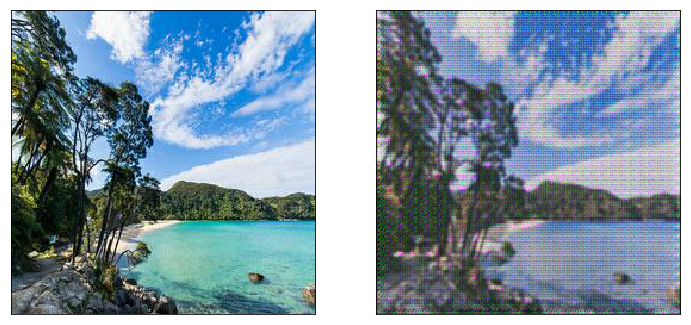

In [136]:
rd_photos_np=np.zeros([2,256,256,3])
rd_photos_np[0,:,:,:]=np.reshape(plt.imread('photo_jpg/'+random.choice(photo_val_im_names)),[256,256,3])/255.0
rd_photos_np[1,:,:,:]=np.reshape(plt.imread('photo_jpg/'+random.choice(photo_val_im_names)),[256,256,3])/255.0
fake_monets=photo_to_monet.predict(rd_photos_np)
fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].imshow(rd_photos_np[0,:,:,:])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].imshow(fake_monets[0,:,:,:])
plt.show()

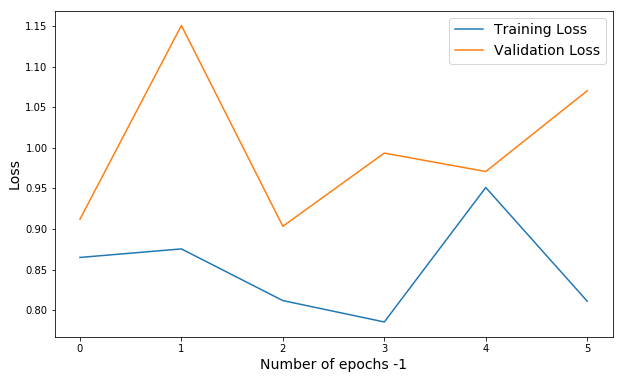

In [118]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(stats_mg.train_loss_history,label='Training Loss')
plt.plot(stats_mg.val_loss_history,label='Validation Loss')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.legend(loc="upper right", fontsize=14)

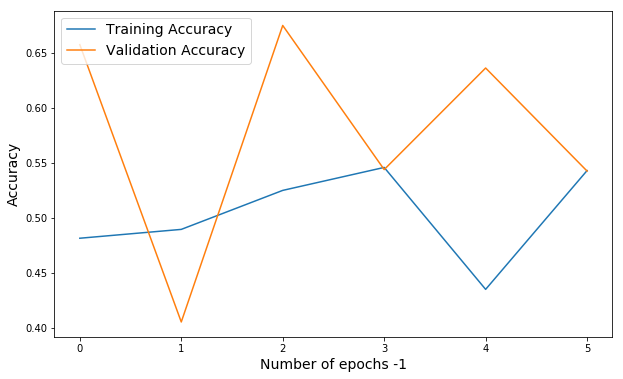

In [119]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(stats_mg.train_accuracy_history,label='Training Accuracy')
plt.plot(stats_mg.val_accuracy_history,label='Validation Accuracy')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.legend(loc="upper left", fontsize=14)

Following is the routine to pack all these artistic creations into a zip file to submit to Kaggle. It grabs all the photos of the photo_jpg folder, batch by batch. It pushes each batch through the generator network, then, one by one, saves the image in the working directory, just for zipfile to grab it and push it through the archive. Then after a short sleep time to avoid jams, os destroys the file.

Unless you really liked my work, do not run this routine on your machine, as it will eat up about a quarter of a GB from your hard drive after decompression. I am commenting it for this reason.

In [120]:
# Saves the weights of the networks above to avoid retraining just the autoencoders
#np.savez('../tmp/monet_to_photo_weightsSubmit2',monet_to_photo.get_weights())
#np.savez('../tmp/photo_to_monet_weightsSubmit2',photo_to_monet.get_weights())
#np.savez('../tmp/discriminator_weightsSubmit2',discriminator.get_weights())

In [229]:
#start_time=time.time()
# This function deletes some files it creates. Do not modify. It is commented because it writes on the hard drive
#import zipfile
#
#input_path=path_photo+'/'
#zip_filename='images.zip'
#batch_size_submit=102
#batch=np.zeros([batch_size_submit,256,256,3])
#for batch_idx in range(m_photo//batch_size_submit):
#    for batch_line in range(batch_size_submit):
#        batch[batch_line]=np.reshape(plt.imread(input_path+photo_im_names[batch_idx*batch_size_submit+batch_line]),
#                                     [256,256,3])/255.0
#    fakes=photo_to_monet.predict(batch)
#    for batch_line in range(batch_size_submit):
#        jpg_filename='fake'+photo_im_names[batch_idx*batch_size_submit+batch_line]
#        plt.imsave(jpg_filename,fakes[batch_line])
#        with zipfile.ZipFile(zip_filename,'a') as myzip:
#            myzip.write(jpg_filename)
#        time.sleep(0.005)
#        if os.path.exists(jpg_filename): 
#            os.remove(jpg_filename)
#end_time=time.time() 
#time_spent_training = end_time - start_time
#print('\nIt took '+str(int(time_spent_training)//60)+' minutes and '+str(int(time_spent_training)%60)+' seconds to train')  # This function deletes some files it creates. Do not modify. It is commented because it writes on the hard drive

## Step 4: results

### Hyperparameter search

Rather than a quantitative search for values, the hyperparameter search took the form of a series of iterations using different design choices: retrain autoencoders or not, bias use, type of normalization layers, callbacks, type of optimizer, type of loss, type of output activation function etc... These results are presented first as a narative to show the progression from earlier iterations. A summary is included in the form of a table.

The first iteration did not train the monet_to_photo and the photo_to_monet iterations to autoencode pictures individually. As a result, the combined autoencoders learned latent representations that were not constrained to be pictures distribution. The resulting creations of the generator network were a poor match for Monets and the discriminator quickly learned to tell which was which. The generator pursed the only strategy it had learned with the very first batch that did not fool the discriminator after the second batch endlessly to no end: the result was bad. To attempt to the deterioration of the images, the autoencoders were trained again to attempt to undo the bad effect of the discriminator.

Other suboptimal choices included the use of the Mean Absolute Error to train the autoencoder going with a linear output layer, which forced the output images to be run through a function clipping pixel values between 0 and 1. Networks included no InstanceNormalization layers and they included biases.

The second iteration was much like the first one, except that it did not include a retraining of the autoencoders to attempt to undo the traumatizing effect of the discriminator.

The third iteration included training both the photo_to_monet and the monet_to_photo autoencoders on pictures. It made a large difference. Consequently, there was no need to retrain the autoencoders after adversarial training of the generator with the discriminator. Batch Normalization was added in the hope that it would prevent the discriminator from using contrast to disqualify the generator's efforts, but it had no effect. The images obtained were better, but it was not possible to go through a batch of adversarial training without seeing the discriminator win. The number of trials afforted to the generator to get better before the discriminator would update just made the problem worse: the generator would learn an early winning strategy which was discovered by the discriminator and could not learn anything else.

The fourth iteration included training the monet_to_photo autoencoder with photos and the photo_to_monet with Monets only. This was a mistake, because it did not allow the latent of the Monet to Monet autoencoder to represent the pixels of a a photo. It was corrected. Otherwise, in the autoencoders, Batch Normalization was replaced with Instance Normalization which centers and rescales the output without the contribution of other examples from the same batch, which actually allows learning pictures with an appropriate level of contrast. However, the discriminator would just worsen the fact that latents of the Monet to Monet autoencoder were not distributed like the pixels of a photo. It also included 3 Batch Normalization layers 

This fifth iteration included Instance Normalization in both the autoencoders and the discriminator. This also made it possible to use sigmoid layer outputs with all the networks and therefore the binary crossentropy loss which goes with it. In addition, a second callback on the generator was introduced, to limit inappropriately excessive learning on the part of the generator as to keep it in pace with the discriminator. The sixth and seventh versions are the similar: the seventh version has the ability to store weights and the initial training of the autoencoders were done on the whole data. Because the second part of this notebook requires GPU accelleration which is a fee for service feature on Kaggle, the file submitted to get a score was made using the photo to monet network before it was trained with adversarial training. On a CPU, it got done below 5 hours. 

The final iteration was much like the fifth one, with three exceptions.
- Because it easily became impossible for the generator to catch up, even when given 300 opportunities, it was necessary to build a generator with less bias. In the iterations until then, both the photo to monet and monet to photo network only had 2 convolutional and 2 deconvolutional layers. We added one of each along with with residuals as the network was getting deeper.
- We found a threshold for the generator of 50 % was adequate: after all if you play tennis with a friend, you want to be able to beat them about half the time. If not you and your friend will eventually become disinterested with the sport: one of you will stop trying. But there are limits in the number of hours people can play. So we gave the generator an opportunity for 100 redos, but limited stopped them when it beat the discriminator half the time.
- We added back a little bit of cycle loss.

### Table

In [5]:
import pandas as pd

index_list=['First iteration','Second iteration','Third iteration','Fourth iteration','Fifth iteration','Sixth iteration']
column_list=['Retraining combined AEs','Training elemental AEs','MAE for AEs','Cross-ent. AEs','Batch Norm. AEs',
             'Batch Norm. disc.','Instance Norm AEs','Instance Norm disc.','Extra layers, Residuals','Generator callback',
             'Cycle loss','Success']
y='yes'
n='no'
values=[[y,n,y,n,n,n,n,n,n,n,n,n],[n,n,y,n,n,n,n,n,n,n,n,n],[n,y,y,n,y,y,n,n,n,n,n,'some'],[n,y,y,n,n,y,y,n,n,n,n,'some'],
        [n,y,n,y,n,n,y,y,n,y,n,y],[n,y,n,y,n,n,y,y,y,y,y,y]]
table_df=pd.DataFrame(values,index=index_list,columns=column_list)
table_df.head(6)

,Retraining combined AEs,Training elemental AEs,MAE for AEs,Cross-ent. AEs,Batch Norm. AEs,Batch Norm. disc.,Instance Norm AEs,Instance Norm disc.,"Extra layers, Residuals",Generator callback,Cycle loss,Success
First iteration,yes,no,yes,no,no,no,no,no,no,no,no,no
Second iteration,no,no,yes,no,no,no,no,no,no,no,no,no
Third iteration,no,yes,yes,no,yes,yes,no,no,no,no,no,some
Fourth iteration,no,yes,yes,no,no,yes,yes,no,no,no,no,some
Fifth iteration,no,yes,no,yes,no,no,yes,yes,no,yes,no,yes
Sixth iteration,no,yes,no,yes,no,no,yes,yes,yes,yes,yes,yes


##### Legend

Retraining combined AEs: Monet to Monet and Photo to Photo autoencoders were retrained after each cycle of adversarial training

Training elemental AEs: photo to monet and monet to photo audoencoders were trained on photos and Monets too.

MAE for AEs: the Mean Absolute Error was used as a loss when training autoencoders along with linear output layers

Cross-ent AEs: the binary cross-entropy loss was used when training autoencoders along with sigmoid output layers

Batch Norm. AEs: batch normalization was included in autoencoder models

Batch Norm. disc: batch normalization was included in discriminator model

Instance Norm AEs: instance normalization was included in autoencoder models

Instance Norm. disc: instance normalization was included in discriminator model

Success: "yes": adversarial training improved adversarial loss; "no": it made it worse; "some": it did not make it worse


## Step 5: Conclusion

CycleGAN is a very effective method to create fake paintings resembling the works of master artists like Monet. In this work, we were able to implement a Generative Adversarial Network inspired from CycleGAN and produce fakes with Monet's stylistic features, albeit of a much lesser quality. It took many iterations. To go further, autoencoder and discriminator networks could be improved, adding more layers with residuals the way Amy Jang did. The entire CycleGAN could be implemented, which includes training the autoencoders as each of their components undergoes adversarial training with two dedicated discriminator networks, one to obtain Monet fakes from photos, the other fake photos from Monet paintings. This work was done in the context of an exercise for a class, with its associated deadlines, which limits the time alloted to further development.

Making fakes of very high quality with a simple cluster has become easy. This is a matter of worries. We cannot trust what we see anymore, when watching a video or a photograph. They could just be fakes.

#### Bibliography

[1] Ian J. Goodfellow, Pouget-Abadie J., Mirza M., Xu B., Warde-Farley D., Ozair S., Courville A., Bengio Y. (2014). Generative Adversarial Networks. In NIPS'2014. 

[2] Jonathan Hui (2018). GAN - What is Generative Adversarial Networks GAN? Medium
https://jonathan-hui.medium.com/gan-whats-generative-adversarial-networks-and-its-application-f39ed278ef09

[3] Jonathan Hui (2018). GAN - CycleGAN (Playing magic with pictures). Medium
https://jonathan-hui.medium.com/gan-cyclegan-6150e7600d7

[4] Amy Jang (2020). Monet CycleGAN Tutorial. Kaggle
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

[5] Amy Jang, Ana Sofia Uzsoy, Phil Culliton (2020). I'm Something of a Painter Myself. Kaggle
https://kaggle.com/competitions/gan-getting-started